# Movie Recommendation System

In this notebook, we will build a simple movie recommendation system using the MovieLens dataset. The goal is to recommend movies based on user preferences and similarity between movies.



## Steps:
1. Load the dataset.
2. Clean the movie titles.
3. Use TF-IDF to vectorize the movie titles.
4. Implement a search function to find similar movies.
5. Build a recommendation system based on user ratings.

Let's get started Nerdators!

In [ ]:
import pandas as pd
movies=pd.read_csv("./ml-25m/movies.csv")
movies.head(20)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
5,6,Heat (1995),Action|Crime|Thriller
6,7,Sabrina (1995),Comedy|Romance
7,8,Tom and Huck (1995),Adventure|Children
8,9,Sudden Death (1995),Action
9,10,GoldenEye (1995),Action|Adventure|Thriller


In [10]:
ratings = pd.read_csv("./ml-25m/ratings.csv")
ratings.head(20)

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510
5,1,1088,4.0,1147868495
6,1,1175,3.5,1147868826
7,1,1217,3.5,1147878326
8,1,1237,5.0,1147868839
9,1,1250,4.0,1147868414


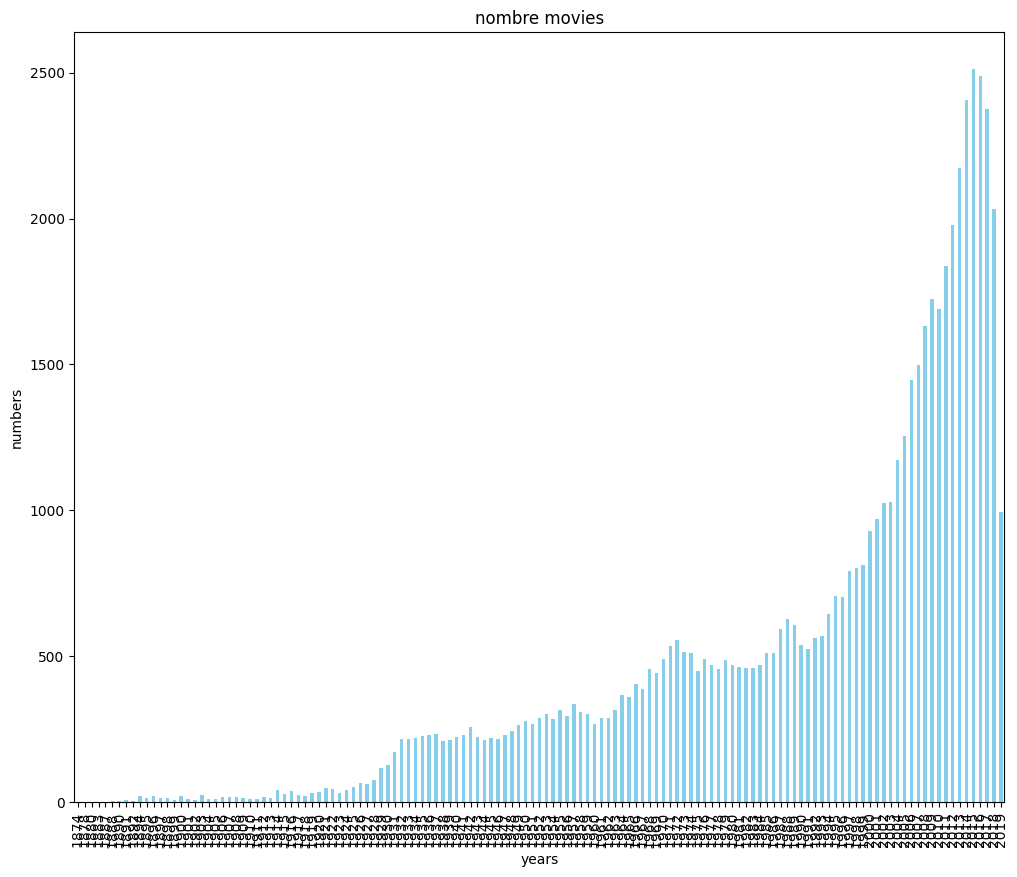

In [11]:
import matplotlib.pyplot as plt

movies['year'] = movies['title'].str.extract(r'\((\d{4})\)')
plt.figure(figsize=(12,10))

movies['year'].value_counts().sort_index().plot(kind='bar',color='skyblue')
plt.title('nombre movies')
plt.xlabel('years')
plt.ylabel('numbers')
plt.show()

In [12]:
import re

def clean_title(title):
    title = re.sub("[^a-zA-Z0-9 ]" ,"" ,title)
    return title

movies['clean_title']=movies['title'].apply(clean_title)

movies.head()

,movieId,title,genres,year,clean_title
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995,Toy Story 1995
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995,Jumanji 1995
2,3,Grumpier Old Men (1995),Comedy|Romance,1995,Grumpier Old Men 1995
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995,Waiting to Exhale 1995
4,5,Father of the Bride Part II (1995),Comedy,1995,Father of the Bride Part II 1995


In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(ngram_range=(1,2))
tfidf = vectorizer.fit_transform(movies["clean_title"])


In [14]:
import ipywidgets as widgets
from IPython.display import display
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

movie_input = widgets.Text(
    value='Toy Story',  
    description='Movie Title:',  
    disabled=False 
)

def search(title):
    title = clean_title(title)
    query_vec = vectorizer.transform([title])
    similarity = cosine_similarity(query_vec, tfidf).flatten()  
    indices = np.argpartition(similarity, -5)[-5:]  
    results = movies.iloc[indices].iloc[::-1]
    
    return results

movie_list = widgets.Output()

def on_type(data):
    with movie_list:
        movie_list.clear_output()  
        title = data["new"]  
        if len(title) > 5:  
            display(search(title))  
movie_input.observe(on_type, names='value')  

display(movie_input, movie_list)


Text(value='Toy Story', description='Movie Title:')

Output()

In [15]:
def find_similar_movies(movie_id):
    similar_users = ratings[(ratings["movieId"] == movie_id) & (ratings["rating"] > 4)]["userId"].unique()
    similar_user_recs = ratings[(ratings["userId"].isin(similar_users)) & (ratings["rating"] > 4)]["movieId"]
    similar_user_recs = similar_user_recs.value_counts() / len(similar_users)
    similar_user_recs = similar_user_recs[similar_user_recs > 0.10]
    all_users = ratings[(ratings["movieId"].isin(similar_user_recs.index)) & (ratings["rating"] > 4)]
    all_user_recs = all_users["movieId"].value_counts() / len(all_users["userId"].unique())
    rec_percentages = pd.concat([similar_user_recs, all_user_recs], axis=1)
    rec_percentages.columns = ["similar", "all"]
    rec_percentages["score"] = rec_percentages["similar"] / rec_percentages["all"]
    rec_percentages = rec_percentages.sort_values("score", ascending=False)
    return rec_percentages.head(10).merge(movies, left_index=True, right_on="movieId")[["score", "title", "genres"]]


In [16]:
import ipywidgets as widgets
from IPython.display import display

movie_name_input = widgets.Text(
    value='Toy Story',
    description='Movie Title:',
    disabled=False
)
recommendation_list = widgets.Output()

def on_type(data):
    with recommendation_list:
        recommendation_list.clear_output()
        title = data["new"]
        if len(title) > 5:
            results = search(title)
            movie_id = results.iloc[0]["movieId"]
            display(find_similar_movies(movie_id))
            
movie_name_input.observe(on_type, names='value')
display(movie_name_input, recommendation_list)

Text(value='Toy Story', description='Movie Title:')

Output()